In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [11]:
# DnCNN Model Definition, Data Prep, and Training Loop for Colab
"""
Define, inspect, prepare data, and train the DnCNN denoiser interactively in a Colab notebook.
Includes utilities for computing dataset statistics, loading from ZIPs, and a basic train/val loop
that tracks both MSE loss and SSIM.
"""
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import DataLoader
import zipfile, io
from PIL import Image
from tqdm import tqdm
import math
from pathlib import Path
import torch.nn.functional as F
from pytorch_msssim import ssim
import os
import random
import matplotlib.pyplot as plt


In [24]:
# ---------------------------------------------
# 1. RIDNet Definition
# ---------------------------------------------
class FeatureAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        scale = self.fc(self.pool(x))
        return x * scale

class EAMBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.dilated_conv1 = nn.Conv2d(channels, channels, 3, padding=1, dilation=1)
        self.dilated_conv2 = nn.Conv2d(channels, channels, 3, padding=2, dilation=2)
        self.residual = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )
        self.enhanced = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )
        self.attention = FeatureAttention(channels)
    def forward(self, x):
        d1 = self.dilated_conv1(x)
        d2 = self.dilated_conv2(x)
        merged = d1 + d2
        res = self.residual(merged) + merged
        enh = self.enhanced(res) + res
        out = self.attention(enh)
        return out + x

class RIDNet(nn.Module):
    def __init__(self, in_channels=1, num_features=64, num_blocks=4):
        super().__init__()
        self.entry = nn.Conv2d(in_channels, num_features, 3, padding=1)
        self.blocks = nn.Sequential(*[EAMBlock(num_features) for _ in range(num_blocks)])
        self.exit = nn.Conv2d(num_features, in_channels, 3, padding=1)
    def forward(self, x):
        identity = x
        out = self.entry(x)
        out = self.blocks(out)
        out = self.exit(out)
        return identity - out


In [20]:
# ---------------------------------------------
# 2. Transforms with Resize
# ---------------------------------------------
mean, std = [0.1781], [0.1976]
target_size = (256,256)
train_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
val_tf = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [17]:
# ---------------------------------------------
# 3. Paired ZIP Dataset Loader
# ---------------------------------------------
class PairedZipDataset(torch.utils.data.Dataset):
    def __init__(self, clean_zip, noisy_zip, transform=None):
        self.clean_zip_path = clean_zip
        self.noisy_zip_path = noisy_zip
        with zipfile.ZipFile(clean_zip, 'r') as zc:
            self.fnames = sorted(
                Path(f).name for f in zc.namelist()
                if f.startswith('clean/') and f.lower().endswith(('.png','.jpg','.jpeg','.tif','.tiff'))
            )
        self.transform = transform or (lambda x: x)
        self.zc, self.zn = None, None
    def __len__(self): return len(self.fnames)
    def __getitem__(self, idx):
        if self.zc is None: self.zc = zipfile.ZipFile(self.clean_zip_path)
        if self.zn is None: self.zn = zipfile.ZipFile(self.noisy_zip_path)
        fname = self.fnames[idx]
        clean = Image.open(io.BytesIO(self.zc.read(f'clean/{fname}'))).convert('L')
        noisy = Image.open(io.BytesIO(self.zn.read(f'noisy/{fname}'))).convert('L')
        return self.transform(noisy), self.transform(clean)

In [ ]:
# ---------------------------------------------
# 4. Training Loop with Denormalized Metrics & Early Stopping
# ---------------------------------------------
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3,
                patience=5, checkpoint_dir='checkpoints', device=None):
    print(f">>> train_model called: epochs={epochs}, lr={lr}, patience={patience}")
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    os.makedirs(checkpoint_dir, exist_ok=True)
    best_val_loss, epochs_no_improve = float('inf'), 0

    for ep in range(1, epochs+1):
        print(f"--- Starting Epoch {ep}/{epochs} ---")
        model.train()
        train_loss = train_ssim_sum = 0.0
        for noisy, clean in tqdm(train_loader, desc=f"Epoch {ep}/{epochs} [Train]", leave=False):
            noisy, clean = noisy.to(device), clean.to(device)
            pred = model(noisy)
            loss = criterion(pred, clean)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            train_loss += loss.item() * noisy.size(0)
            batch_ssim = ssim(pred, clean, data_range=1.0, size_average=True).item()
            train_ssim_sum += batch_ssim * noisy.size(0)
        train_loss /= len(train_loader.dataset)
        train_ssim = train_ssim_sum / len(train_loader.dataset)

        model.eval()
        val_loss = val_ssim_sum = psnr_sum = 0.0
        for noisy, clean in tqdm(val_loader, desc=f"Epoch {ep}/{epochs} [Val]", leave=False):
            noisy, clean = noisy.to(device), clean.to(device)
            pred = model(noisy)
            val_loss += criterion(pred, clean).item() * noisy.size(0)
            batch_ssim = ssim(pred, clean, data_range=1.0, size_average=True).item()
            val_ssim_sum += batch_ssim * noisy.size(0)
            mse = (pred-clean).pow(2).mean().item()
            psnr_sum += 10 * math.log10(1.0 / mse) * noisy.size(0)
        val_loss /= len(val_loader.dataset)
        val_ssim = val_ssim_sum / len(val_loader.dataset)
        avg_psnr = psnr_sum / len(val_loader.dataset)

        print(f"Epoch {ep}/{epochs}: Train MSE={train_loss:.4f}, Train SSIM={train_ssim:.4f} | "
              f"Val MSE={val_loss:.4f}, Val SSIM={val_ssim:.4f}, Val PSNR={avg_psnr:.2f}dB")

        if val_loss < best_val_loss:
            best_val_loss = val_loss; epochs_no_improve = 0
            ckpt = os.path.join(checkpoint_dir, f'best_ep{ep}.pth')
            torch.save(model.state_dict(), ckpt)
            print(f"  Saved checkpoint: {ckpt}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {ep}")
                break

In [ ]:
# ---------------------------------------------
# 5. DataLoaders & Training
# ---------------------------------------------
train_ds = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/train_clean.zip','/content/drive/MyDrive/IA2/dataset/train_noisy.zip',train_tf)
val_ds   = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/val_clean.zip','/content/drive/MyDrive/IA2/dataset/val_noisy.zip',val_tf)
train_loader = DataLoader(train_ds,batch_size=8,shuffle=True,num_workers=0)
val_loader   = DataLoader(val_ds,  batch_size=8,shuffle=True,num_workers=0)
model = RIDNet(in_channels=1,num_features=64,num_blocks=4)
train_model(model,train_loader,val_loader)

>>> train_model called: epochs=50, lr=0.001, patience=5
--- Starting Epoch 1/50 ---


Epoch 1/50: Train MSE=0.1444, Train SSIM=0.5760 | Val MSE=0.0939, Val SSIM=0.6190, Val PSNR=10.80dB
  Saved checkpoint: checkpoints/best_ep1.pth
--- Starting Epoch 2/50 ---


Epoch 2/50: Train MSE=0.0917, Train SSIM=0.6052 | Val MSE=0.0858, Val SSIM=0.5855, Val PSNR=10.97dB
  Saved checkpoint: checkpoints/best_ep2.pth
--- Starting Epoch 3/50 ---


Epoch 3/50: Train MSE=0.0756, Train SSIM=0.6205 | Val MSE=0.0688, Val SSIM=0.6170, Val PSNR=12.05dB
  Saved checkpoint: checkpoints/best_ep3.pth
--- Starting Epoch 4/50 ---


Epoch 4/50: Train MSE=0.0635, Train SSIM=0.6448 | Val MSE=0.0531, Val SSIM=0.6413, Val PSNR=13.19dB
  Saved checkpoint: checkpoints/best_ep4.pth
--- Starting Epoch 5/50 ---


Epoch 5/50: Train MSE=0.0526, Train SSIM=0.6664 | Val MSE=0.0499, Val SSIM=0.6511, Val PSNR=13.38dB
  Saved checkpoint: checkpoints/best_ep5.pth
--- Starting Epoch 6/50 ---


Epoch 6/50: Train MSE=2708211692783977.0000, Train SSIM=0.5996 | Val MSE=18994271113.2160, Val SSIM=0.0000, Val PSNR=-101.85dB
--- Starting Epoch 7/50 ---


Epoch 7/50: Train MSE=1645220454.3653, Train SSIM=0.0000 | Val MSE=25957209.3120, Val SSIM=-0.0000, Val PSNR=-74.12dB
--- Starting Epoch 8/50 ---


Epoch 8/50: Train MSE=20356535.1187, Train SSIM=-0.0000 | Val MSE=19292260.0200, Val SSIM=-0.0000, Val PSNR=-72.83dB
--- Starting Epoch 9/50 ---


Epoch 9/50: Train MSE=13597385.3400, Train SSIM=0.0000 | Val MSE=11398207.3000, Val SSIM=-0.0000, Val PSNR=-70.54dB
--- Starting Epoch 10/50 ---


Epoch 10/50: Train MSE=10306861.1660, Train SSIM=0.0000 | Val MSE=7337779.9580, Val SSIM=0.0000, Val PSNR=-68.63dB
Early stopping at epoch 10


In [ ]:
# ---------------------------------------------
# 6. Sync checkpoints to Google Drive
# ---------------------------------------------
import shutil

dst_dir = '/content/drive/MyDrive/IA2/ridnet_checkpoints'
shutil.copytree('checkpoints', dst_dir, dirs_exist_ok=True)
print(f"Checkpoints have been copied to {dst_dir}")


Checkpoints have been copied to /content/drive/MyDrive/IA2/ridnet_checkpoints


In [38]:
# ---------------------------------------------
# 7. Load Best Checkpoint for Evaluation
# ---------------------------------------------
# Replace with your checkpoint path
best_ckpt = '/content/drive/MyDrive/IA2/ridnet_checkpoints/best_ep5.pth'
model.load_state_dict(torch.load(best_ckpt))
# Continue training for 45 more epochs
train_model(model,
            train_loader,
            val_loader,
            epochs=45,
            lr=1e-4,
            patience=5,
            checkpoint_dir='checkpoints_ridnet_finetune')


NameError: name 'train_model' is not defined

In [ ]:
# ---------------------------------------------
# 6. Sync checkpoints to Google Drive
# ---------------------------------------------
import shutil

dst_dir = '/content/drive/MyDrive/IA2/ridnet_checkpoints_finetune'
shutil.copytree('checkpoints_ridnet_finetune', dst_dir, dirs_exist_ok=True)
print(f"Checkpoints have been copied to {dst_dir}")


Checkpoints have been copied to /content/drive/MyDrive/IA2/ridnet_checkpoints_finetune


In [46]:
# ---------------------------------------------
# 8. Test Set Evaluation
# ---------------------------------------------
# Initialize a fresh RIDNet for testing
# (checkpoint path to be set by user)
model = RIDNet(in_channels=1, num_features=64, num_blocks=4)
# Load best checkpoint (replace with your own path)
best_ckpt = '/content/drive/MyDrive/IA2/ridnet_checkpoints_finetune/best_ep44.pth'
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare test DataLoader
test_ds = PairedZipDataset('/content/drive/MyDrive/IA2/dataset/test_clean.zip', '/content/drive/MyDrive/IA2/dataset/test_noisy.zip', val_tf)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0)

# Collect per-instance metrics
all_mse, all_ssim, all_psnr = [], [], []
with torch.no_grad():
    for noisy, clean in tqdm(test_loader, desc='Testing'):
        noisy, clean = noisy.to(device), clean.to(device)
        pred = model(noisy)
        # denormalize predictions and targets
        pd = pred * std[0] + mean[0]
        cd = clean * std[0] + mean[0]
        # per-image MSE
        per_mse = ((pd - cd) ** 2).mean(dim=[1,2,3]).cpu().tolist()
        all_mse.extend(per_mse)
        # per-image SSIM
        batch_ssim = ssim(pd, cd, data_range=1.0, size_average=False).cpu().tolist()
        all_ssim.extend(batch_ssim)
        # per-image PSNR
        all_psnr.extend([10 * math.log10(1.0 / m) for m in per_mse])

# Compute and print averages
test_mse = sum(all_mse) / len(all_mse)
test_ssim = sum(all_ssim) / len(all_ssim)
test_psnr = sum(all_psnr) / len(all_psnr)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test SSIM: {test_ssim:.4f}")
print(f"Test PSNR: {test_psnr:.2f} dB")


Testing: 100%|██████████| 250/250 [01:19<00:00,  3.15it/s]

Test MSE: 0.0055
Test SSIM: 0.3366
Test PSNR: 24.20 dB


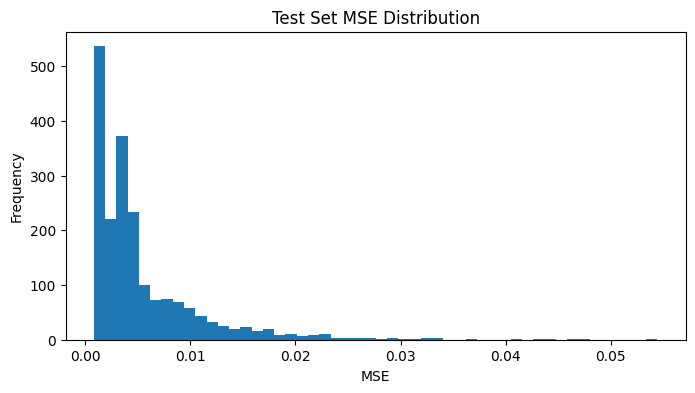

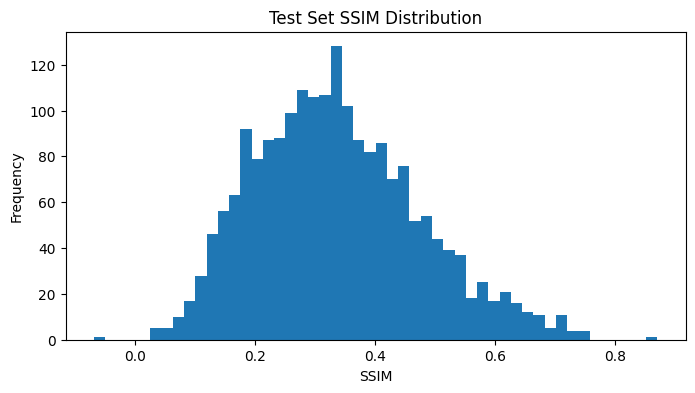

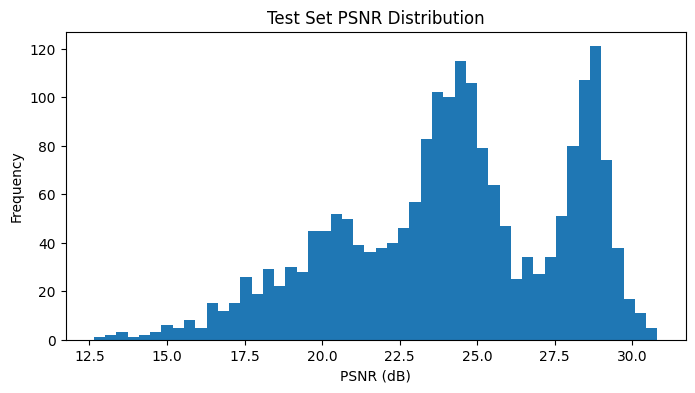

In [49]:
# ---------------------------------------------
# 9. Plot Histograms of Test Metrics
# ---------------------------------------------
plt.figure(figsize=(8,4))
plt.hist(all_mse, bins=50)
plt.title('Test Set MSE Distribution')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(all_ssim, bins=50)
plt.title('Test Set SSIM Distribution')
plt.xlabel('SSIM')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(all_psnr, bins=50)
plt.title('Test Set PSNR Distribution')
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')
plt.show()


In [48]:
# ---------------------------------------------
# 8. Sample Visualizations
# ---------------------------------------------
indices=random.sample(range(len(test_ds)),10)
fig,ax=plt.subplots(10,3,figsize=(9,30))
for i,idx in enumerate(indices):
    n,c=test_ds[idx]
    d=model(n.unsqueeze(0).to(device)).squeeze(0).cpu()
    def den(t):
        # Denormalize and convert to numpy for display
        t_den = t.detach() * std[0] + mean[0]
        return t_den.cpu().numpy().squeeze()
    ax[i,0].imshow(den(d),cmap='gray'); ax[i,0].axis('off'); ax[i,0].set_title('Noisy')
    ax[i,1].imshow(den(n),cmap='gray'); ax[i,1].axis('off'); ax[i,1].set_title('Denoised')
    ax[i,2].imshow(den(c),cmap='gray'); ax[i,2].axis('off'); ax[i,2].set_title('Clean')
plt.tight_layout(); plt.show()

Output hidden; open in https://colab.research.google.com to view.